In [53]:
import numpy as np
import astropy.constants as const
from astropy import units as u
from scipy import interpolate

N_A = 6.02214086e+23
m_e = 9.1093897E-28
k_B = 1.380658E-16
a_rad = 7.5646E-15
c_s = 2.99792458E10
G = 6.67259E-8
m_sun = 2E33
r_sun = 6.957E10
L_sun = 3.839E33
A_H = 1
A_Z = 14
A_He = 4
X = 0.7
Y = 0.28
Z = 0.02
y_H = 1
y_He = 1
y_Z = 1
Z_H = 1
Z_He = 2
Z_Z = 7

mu_i = X/A_H + Y/A_He + Z/A_Z
mu_e = ((X*Z_H*y_H)/A_H) + ((Y*Z_He*y_He)/A_He) + ((Z_Z*Z*y_Z)/A_Z)
mu = 1/(mu_i + mu_e)
print(mu)
table = np.genfromtxt('OPAL_X0.7_Y0.28.dat')
x = table[1:71,0]
y = table[0,1:20]
z = np.genfromtxt('OPAL_X0.7_Y0.28.dat',skip_header = 1, usecols = (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19))

f = interpolate.interp2d(y, x, z, kind='linear')
x_new =np.arange(3,6, 10E-4)
y_new =np.arange(-10,1, 10E-4)
k_table = f(y_new, x_new)

P_c = 10**16.68
T_c = 10**7.46
p_c = (P_c-((1/3)*a_rad*(T_c**4)))/((N_A*k_B/mu)*T_c)
k_c = -1.051
r_c = 0
gamma_c =1.5756511761840426

print(P_c,T_c, p_c)
def energy_generation_central(X,Y,Z, T_c, p_c):
    a = (T_c/(1E9))**(2/3)
    b = (T_c/(1E9))**(1/3)
    j = (T_c/(1E9))**(3)
    d =(T_c/(1E9))
    E_pp_c = (np.exp(-3.38/(b)) * (p_c*(X**2)) *2.4E4)/ (a)
    E_CNO_c =  (np.exp(-15.228/(b))*(p_c*(X*Z))*4.4E25)/(a)
    E_3_c = (np.exp(-4.4/(d)) * (p_c**2)*(Y**3) * 5E8)/(j)
    #E_3_c = 5.0E8*(u.s**2 * u.cm/ u.g**3) * ((p_c**2)*(Y**3)/((T_c/10E9*u.K)**(3))*np.exp(-4.4/(T_c/(10E9*u.K))))
    E_c = (E_pp_c+E_CNO_c+E_3_c)
    return(E_c)
E_c = energy_generation_central(X,Y,Z, T_c, p_c)


def T_R(T, k, p, E ,r):
    T_R = T_c - ((k*(p**2)*E *r**2)/(8*a_rad*c_s*T**3))

    return(T_R)

def T_C(T, k, p, E ,r,P):
    t = (2*(np.pi)*G*p**2)
    b = 3*P
    T_C = T_c -((1-(1/gamma_c))*(t/b)*r**2)
    return(T_C)

def P_r(P, p, r):
    P_r = P -((2/3)*(np.pi)*G*(p**2)*r**2)
    return(P_r)
def p_r(P, T):
    p_r = (P-((1/3)*a_rad*(T**4)))/(((N_A*k_B/mu)*T))
    return (p_r)


def opacity(X, Y , Z,  p, T):
    logT = np.log10(T)
    logR = np.log10(p) - (3 * logT) + 18
    inv_k_e = (0.2*(1+X))
    inv_k_ff = (4E22*(Y+X)*(1+X)*p*T**(-3.5))
    inv_k_bf = (4E25*Z*(1+X)*p*T**(-3.5))
    inv_k_H = (2.5E-31*(Z/0.02)*p**(1/2))
    k_func = 1/(((inv_k_H)**-1) +(inv_k_e+inv_k_ff+inv_k_bf)**-1)
    k_log = float(f(logR, logT))
    #print(k_log)
    if T > 10**(8.7):
        k = k_func
    #elif T<= 10**(3.75):
        k = k_func
    #elif p > (10**-8.0 * (T**3) / ((1E6)**3)):
        k = k_func
    #elif p < (10**1 * (T**3) / ((1E6)**3)):
        k= k_func
    else:
        k =10** (k_log)
    return(k)
def beta_r(T,p):
    beta_r = (((N_A*k_B/mu)*p*T))/(((1/3)*a_rad*T**4) + ((N_A*k_B/mu)*p*T))
    #print(N_A,k_B,mu,p,T,a)
    return(beta_r)
def gamma_r(beta):
    gamma_r = (32 - 24*beta - 3*beta**2)/(24 - 18*beta - 3*beta**2)
    return(gamma_r)

def energy_generation(X,Y,Z, T, p):
    a = (T/(1E9))**(2/3)
    b = (T/(1E9))**(1/3)
    j = (T/(1E9))**(3)
    d =(T/(1E9))
    E_pp = (np.exp(-3.38/(b)) * (p*(X**2)) *2.4E4)/ (a)
    E_CNO =  (np.exp(-15.228/(b))*(p*(X*Z))*4.4E25)/(a)
    E_3 = (np.exp(-4.4/(d)) * (p*2)*(Y**3) * 5E8)/(j)
    E = (E_pp+E_CNO+E_3)
    return(E)

 




0.6167400881057269
4.78630092322638e+16 28840315.031266056 11.861528382981676


In [76]:
   #central values
Mstar = 7.08*m_sun
Nsteps = 10000
dm= Mstar/Nsteps
m = np.linspace(dm, Mstar ,Nsteps)
E_i = energy_generation_central(X,Y,Z, T_c, p_c)
L_i = E_c * m[0]
P_i = P_r(P_c, p_c, r_c)
k_i = opacity(X, Y , Z,  p_c, T_c)
beta_i = beta_r(T_c, p_c)
gamma_i = gamma_r(beta_i)
p_i = p_c
r_i = (3*m[0]/(4*(np.pi) *p_i))**(1/3)
if L_i > ((16*np.pi*a_rad*c_s*G/(3*k_i))*(1-(1/gamma_i))*T_c**4*m[0]/P_c):
    T_i = T_C(T_c, k_c, p_c, E_c ,r_c, P_c)
else:
    T_i = T_R(T_c, k_c, p_c, E_c ,r_c)


In [69]:
#derivatives

def dr(r, p_r):
    dr = dm *1/(4*(np.pi)*r**2*p1)
    return(dr)
def dP(m,r):
    dP = - dm *(G*m)/(4*np.pi*r**4)
    return(dP)
def dL(L_c,X,Y,Z, T, p):
    dL = (energy_generation(X,Y,Z, T, p) * dm)


def dT_R(gamma, T_r, r, P_r):
    dT = - dm *(1-(1/gamma))*G*m*T_r/(4*np.pi*r**4*P_r)
    return(dT_R)
def dr(m, p):
    r_ = (((3*m)/4*np.pi*p_c)**(1/3))
    return(r_)

P_1 = P_i
p_1 = p_i
T_1 = T_i
L_1 = E_i*m[0]
k_1 = k_i
r_1 = r_i
E_1 = E_i
gamma_1 = gamma_i
P = []
p = []
T = []
L = []
k = []
E = []
r = []
gamma = []
print(r_i)
for n in range(len(m)):

    r_2 = r_1 + (1/(4*np.pi*r_1**2*p_1))*dm
    P_2 =  P_1 - (dm *(G*m[n])/(((4*np.pi*r_1**4))))
    if L_1 > ((16*np.pi*a_rad*c_s*G/(3*k_1))*(1-(1/gamma_r(beta_1)))*T_1**4*m[n]/P_1):
        T_2 = T_1-(dm*(1-(1/gamma_r(beta_1)))*G*m[n]*T_1)/(4*np.pi*(r_1**4)*P_1)
    else:
        T_2 = T_1 - ((dm*(3*k_1*L_1)/((64*(np.pi**2)*a_rad*c_s*(r_1**4)*T_1**3))))

    L_2 = L_1 + (energy_generation(X,Y,Z, T_1, p_1) * dm)
    p_2 = p_r(P_2, T_2)
    if p_2 < 0 or T_2 <0 or P_2 < 0:
        print('went at shell', n)
        break
    beta_2 = beta_r(T_2, p_2)
    gamma_2 = gamma_r(beta_2)
    k_2 = opacity(X, Y , Z,  p_2, T_2)
    E_2 = (energy_generation(X,Y,Z, T_2, p_2))

    P.append(P_1)
    p.append(p_1)
    T.append(T_1)
    L.append(L_1)
    k.append(k_1)
    r.append(r_1)
    E.append(E_1)
    gamma.append(gamma_1)


    r_1 = r_2
    p_1 = p_2
    P_1 = P_2
    L_1 = L_2
    k_1 = k_2
    T_1 = T_2
    E_1 = E_2
    gamma_1 = gamma_2
adi_ratio = L/((16*np.pi*a_rad*c_s*G/(3*np.array(k))*(1-(1/np.array(gamma)))*np.array(T)**4*m[0:9758]/np.array(P)))

3054531891.840427
went at shell 9758


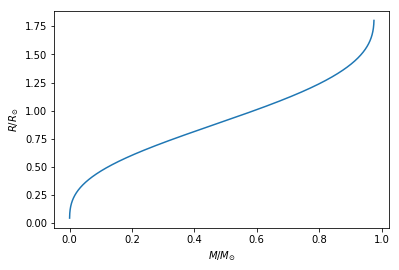

In [56]:
import matplotlib.pyplot as plt
plt.plot( m[0:9758]/Mstar, np.array(r)/r_sun)
plt.xlabel('$M/M_{\odot}$')
plt.ylabel('$R/R_{\odot}$')
plt.savefig('mvr.png', bbox_inches='tight')

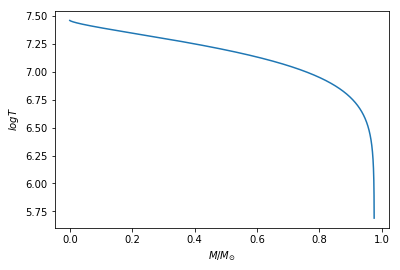

In [57]:
plt.plot( m[0:9758]/Mstar, np.log10(T))
plt.xlabel('$M/M_{\odot}$')
plt.ylabel('$logT$')
plt.savefig('mvlogT.png', bbox_inches='tight')


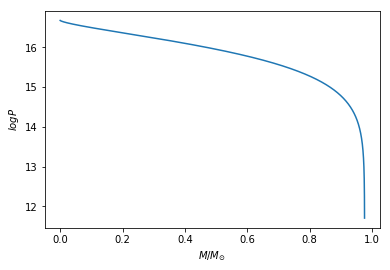

In [74]:
plt.plot( m[0:9758]/Mstar, np.log10(P))
plt.xlabel('$M/M_{\odot}$')
plt.ylabel('$logP$')
plt.savefig('mvlogP.png', bbox_inches='tight')


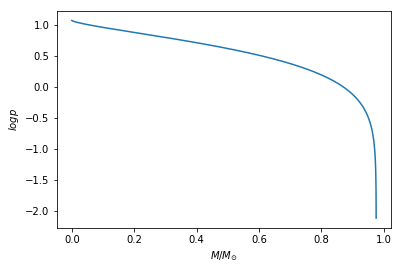

In [59]:
plt.plot( m[0:9758]/Mstar, np.log10(p))
plt.xlabel('$M/M_{\odot}$')
plt.ylabel('$logp$')
plt.savefig('mvlogp.png', bbox_inches='tight')


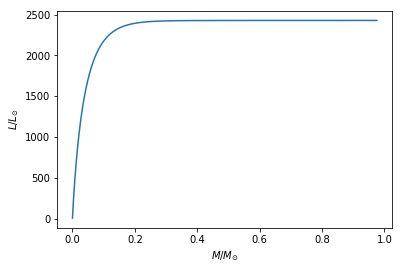

In [63]:
plt.plot( m[0:9758]/Mstar,np.array(L)/L_sun )
plt.xlabel('$M/M_{\odot}$')
plt.ylabel('$L/L_{\odot}$')
plt.savefig('mvL.png', bbox_inches='tight')


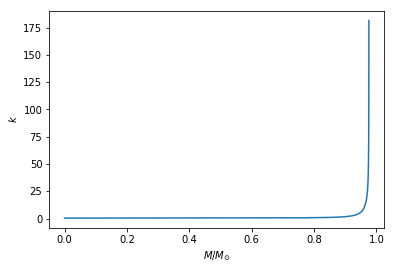

In [75]:
plt.plot( m[0:9758]/Mstar,np.array(k) )
plt.xlabel('$M/M_{\odot}$')
plt.ylabel('$k$')
plt.savefig('mvlogk.png', bbox_inches='tight')


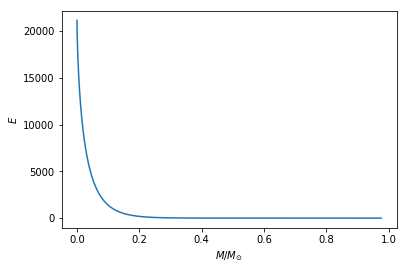

In [65]:
plt.plot( m[0:9758]/Mstar,E )
plt.xlabel('$M/M_{\odot}$')
plt.ylabel('$E$')
plt.savefig('mvE.png', bbox_inches='tight')


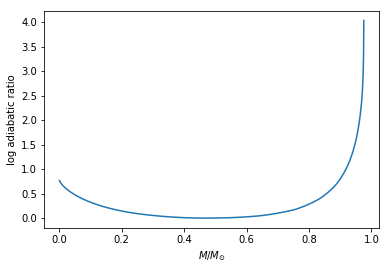

In [73]:
plt.plot( m[0:9758]/Mstar,np.log10(adi_ratio) )
plt.xlabel('$M/M_{\odot}$')
plt.ylabel('log adiabatic ratio')
plt.savefig('mvadi.png', bbox_inches='tight')
